### Dataset Description:

We will use the bAbI dataset from Meta Research.

Dataset link: https://research.facebook.com/downloads/babi/

This project follows:
Sainbayar Sukhbaatar, Arthur Szlam, Jason Weston, Rob Fergus. End-To-End Memory Networks, arXiv:1503.08895v5, 2015.

Research paper link: https://arxiv.org/pdf/1503.08895.pdf

In [1]:
##imports
import pickle
import numpy as np

In [2]:
##load data

with open('train_qa.txt', 'rb') as file:
    train_data = pickle.load(file)
    
with open('test_qa.txt', 'rb') as file:
    test_data = pickle.load(file)

#### Dataset Exploration

In [3]:
train_data[0]

(['Mary',
  'moved',
  'to',
  'the',
  'bathroom',
  '.',
  'Sandra',
  'journeyed',
  'to',
  'the',
  'bedroom',
  '.'],
 ['Is', 'Sandra', 'in', 'the', 'hallway', '?'],
 'no')

In [4]:
##print first five (story, question, answer) tuples in train_data
for (story, query, answer) in train_data[:5]:
    print(f"Story: {' '.join(story)}")
    print(f"Query: {' '.join(query)}")
    print(f"Answer: {answer}")
    print("\n\n")

Story: Mary moved to the bathroom . Sandra journeyed to the bedroom .
Query: Is Sandra in the hallway ?
Answer: no



Story: Mary moved to the bathroom . Sandra journeyed to the bedroom . Mary went back to the bedroom . Daniel went back to the hallway .
Query: Is Daniel in the bathroom ?
Answer: no



Story: Mary moved to the bathroom . Sandra journeyed to the bedroom . Mary went back to the bedroom . Daniel went back to the hallway . Sandra went to the kitchen . Daniel went back to the bathroom .
Query: Is Daniel in the office ?
Answer: no



Story: Mary moved to the bathroom . Sandra journeyed to the bedroom . Mary went back to the bedroom . Daniel went back to the hallway . Sandra went to the kitchen . Daniel went back to the bathroom . Daniel picked up the football there . Daniel went to the bedroom .
Query: Is Daniel in the bedroom ?
Answer: yes



Story: Mary moved to the bathroom . Sandra journeyed to the bedroom . Mary went back to the bedroom . Daniel went back to the hallway 

#### Vectorization

In [5]:
all_data = train_data + test_data

In [6]:
##check max story len
max_story_len = max([len(story) for (story, query, answer) in all_data])
max_story_len

156

In [7]:
##check max query len
max_query_len = max([len(query) for (story, query, answer) in all_data])
max_query_len

6

In [8]:
## setting vocabulary and fitting tokenizer

from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(filters=[]) ##specifying empty iterable for filters to retain punctuations and other markers (such as ?)

##creating vocabulary
vocab = set() ##set is a python iterable generally used for storing unique elements
for (story, query, answer) in all_data:
    vocab = vocab.union(set(story)) ##add any new elements found in story
    vocab = vocab.union(set(query)) ##add any new elements found in query

##adding the 'yes' and 'no' for answer
vocab.add('yes')
vocab.add('no')

##tokenizer fit
tokenizer.fit_on_texts(vocab)

##specifying vocab size
vocab_size = len(vocab) + 1 ##keras needs an extra column for padding

Using TensorFlow backend.


In [9]:
##function for text vectorization

def vectorize(data, word_index=tokenizer.word_index, max_story_len=max_story_len, max_query_len=max_query_len):
    
    inputs_data = list() ##list to contain vectorized stories
    
    queries_data = list() ##list to contain vectorized queries
    
    answers_data = list() ##list to contain categorically encoded answers
    
    ##iteration
    for (story, query, answer) in data:
        
        ##numerically vectorize and append story to inputs_data
        inputs = [word_index[word.lower()] for word in story]
        inputs_data.append(inputs)
        
        ##numerically vectorize, pad, and append query to inputs_data
        queries = [word_index[word.lower()] for word in query]
        queries_data.append(queries)
        
        ##categorically vectorize (sort of like one-hot) and append to answers_data
        answers = np.zeros(len(word_index)+1) ##vocab_size + 1
        answers[word_index[answer]] = 1
        answers_data.append(answers)
        
    ##pad inputs_data and queries_data
    inputs_data = pad_sequences(inputs_data, maxlen=max_story_len, padding='pre')
    queries_data = pad_sequences(queries_data, maxlen=max_query_len, padding='pre')
    
    answers_data = np.array(answers_data)
    
    return inputs_data, queries_data, answers_data

In [10]:
##vectorize train_data and test_data
inputs_train, queries_train, answers_train = vectorize(data=train_data)
inputs_test, queries_test, asnwers_test = vectorize(data=test_data)

In [11]:
inputs_train

array([[ 0,  0,  0, ..., 13, 29, 28],
       [ 0,  0,  0, ..., 13, 35, 28],
       [ 0,  0,  0, ..., 13,  1, 28],
       ...,
       [ 0,  0,  0, ..., 13, 29, 28],
       [ 0,  0,  0, ...,  9, 27, 28],
       [ 0,  0,  0, ..., 18, 27, 28]])

In [12]:
inputs_train.shape

(10000, 156)

In [13]:
queries_train

array([[ 2, 14, 34, 13, 35,  6],
       [ 2, 26, 34, 13,  1,  6],
       [ 2, 26, 34, 13, 15,  6],
       ...,
       [ 2, 14, 34, 13, 35,  6],
       [ 2,  4, 34, 13, 19,  6],
       [ 2,  4, 34, 13, 29,  6]])

In [14]:
queries_train.shape

(10000, 6)

In [15]:
##stacking answers_train into a matrix
##answers_train = np.stack(answers_train)

In [16]:
answers_train

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [17]:
answers_train.shape

(10000, 38)

#### Model Building

In [18]:
from keras.models import Sequential, Model
from keras.layers.embeddings import Embedding
from keras.layers import Permute, Dropout, Input, Dense, Activation
from keras.layers import dot, add, concatenate
from keras.layers import LSTM

In [19]:
input_data = Input((max_story_len,))
query = Input((max_query_len,))

In [20]:
input_encoder_m = Sequential()
input_encoder_m.add(Embedding(input_dim=vocab_size, output_dim=64)) ##output_dim=64 suggested in research paper
input_encoder_m.add(Dropout(rate=0.3)) ##turns off 30% neurons during training to prevent overfitting

##OUTPUT --> (samples, max_story_len, embedding_size=64)

Instructions for updating:
Colocations handled automatically by placer.


In [21]:
input_encoder_c = Sequential()
input_encoder_c.add(Embedding(input_dim=vocab_size, output_dim=max_query_len))
input_encoder_c.add(Dropout(rate=0.3)) ##turns off 30% neurons while training to prevent overfitting

##OUTPUT --> (samples, max_story_len, max_query_len)

In [22]:
query_encoder = Sequential()
query_encoder.add(Embedding(input_dim=vocab_size, output_dim=64, input_length=max_query_len))
query_encoder.add(Dropout(rate=0.3)) ##turns off 30% neurons while training to prevent overfitting

##OUTPUT --> (samples, max_query_len, embedding_size=64)

In [24]:
input_encoded_m = input_encoder_m(input_data)
input_encoded_c = input_encoder_c(input_data)
query_encoded = query_encoder(query)

In [25]:
input_encoded_m

<tf.Tensor 'sequential_1/dropout_1/cond/Merge:0' shape=(?, 156, 64) dtype=float32>

In [26]:
input_encoded_c

<tf.Tensor 'sequential_2/dropout_2/cond/Merge:0' shape=(?, 156, 6) dtype=float32>

In [27]:
query_encoded

<tf.Tensor 'sequential_3/dropout_3/cond/Merge:0' shape=(?, 6, 64) dtype=float32>

In [28]:
match = dot([input_encoded_m, query_encoded], axes=(2,2))
match = Activation('softmax')(match)
match

##OUTPUT --> (samples, max_story_len, max_query_len)

<tf.Tensor 'activation_1/truediv:0' shape=(?, 156, 6) dtype=float32>

In [29]:
response = add([match, input_encoded_c])
response = Permute((2,1))(response) ##(max_story_len, max_query_len) --> (max_query_len, max_story_len)
response

##OUTPUT --> (samples, max_query_len, max_story_len)

<tf.Tensor 'permute_1/transpose:0' shape=(?, 6, 156) dtype=float32>

In [30]:
answer = concatenate([response, query_encoded])
answer

##OUTPUT --> (samples, max_query_len, max_story_len + embedding size)

<tf.Tensor 'concatenate_1/concat:0' shape=(?, 6, 220) dtype=float32>

In [31]:
answer = LSTM(32)(answer)
answer

##OUTPUT --> (samples, 32)

<tf.Tensor 'lstm_1/strided_slice_18:0' shape=(?, 32) dtype=float32>

In [32]:
answer = Dropout(rate=0.5)(answer) ##turns off 50% neurons during training to prevent overfitting
answer = Dense(vocab_size)(answer) ##(samples, 32) --> (samples, vocab_size)
answer

##OUTPUT --> (samples, vocab_size)

<tf.Tensor 'dense_1/BiasAdd:0' shape=(?, 38) dtype=float32>

In [33]:
answer = Activation('softmax')(answer)
answer

<tf.Tensor 'activation_2/Softmax:0' shape=(?, 38) dtype=float32>

In [34]:
model = Model([input_data, query], answer)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 156)          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 6)            0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       multiple             2432        input_1[0][0]                    
__________________________________________________________________________________________________
sequential_3 (Sequential)       (None, 6, 64)        2432        input_2[0][0]                    
____________________________________________________________________________________________

In [35]:
history = model.fit([inputs_train, queries_train], answers_train, batch_size=32, epochs=120, 
                    validation_data=([inputs_test, queries_test], asnwers_test))

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 10000 samples, validate on 1000 samples
Epoch 1/120
10000/10000 [==============================] - 5s 510us/step - loss: 0.9237 - accuracy: 0.4925 - val_loss: 0.6962 - val_accuracy: 0.5030
Epoch 2/120
10000/10000 [==============================] - 4s 415us/step - loss: 0.7058 - accuracy: 0.4935 - val_loss: 0.6996 - val_accuracy: 0.4970
Epoch 3/120
10000/10000 [==============================] - 4s 430us/step - loss: 0.6981 - accuracy: 0.4896 - val_loss: 0.6936 - val_accuracy: 0.4970
Epoch 4/120
10000/10000 [==============================] - 4s 418us/step - loss: 0.6949 - accuracy: 0.5007 - val_loss: 0.6933 - val_accuracy: 0.4970
Epoch 5/120
10000/10000 [==============================] - 4s 395us/step - loss: 0.6950 - accuracy: 0.5010 - val_loss: 0.6947 - val_accuracy: 0.5030
Epoch 6/120
10000/10000 [==============================] - 3s 323us/step - loss:

10000/10000 [==============================] - 4s 370us/step - loss: 0.3059 - accuracy: 0.8698 - val_loss: 0.3567 - val_accuracy: 0.8270
Epoch 52/120
10000/10000 [==============================] - 4s 353us/step - loss: 0.3093 - accuracy: 0.8642 - val_loss: 0.3724 - val_accuracy: 0.8270
Epoch 53/120
10000/10000 [==============================] - 4s 351us/step - loss: 0.3005 - accuracy: 0.8707 - val_loss: 0.3529 - val_accuracy: 0.8340
Epoch 54/120
10000/10000 [==============================] - 4s 363us/step - loss: 0.3008 - accuracy: 0.8727 - val_loss: 0.3661 - val_accuracy: 0.8330
Epoch 55/120
10000/10000 [==============================] - 4s 358us/step - loss: 0.2992 - accuracy: 0.8717 - val_loss: 0.3831 - val_accuracy: 0.8360
Epoch 56/120
10000/10000 [==============================] - 4s 361us/step - loss: 0.2982 - accuracy: 0.8720 - val_loss: 0.3589 - val_accuracy: 0.8330
Epoch 57/120
10000/10000 [==============================] - 4s 377us/step - loss: 0.2959 - accuracy: 0.8728 - val

10000/10000 [==============================] - 5s 543us/step - loss: 0.2299 - accuracy: 0.9027 - val_loss: 0.4771 - val_accuracy: 0.8260
Epoch 106/120
10000/10000 [==============================] - 6s 553us/step - loss: 0.2272 - accuracy: 0.9050 - val_loss: 0.5012 - val_accuracy: 0.8200
Epoch 107/120
10000/10000 [==============================] - 5s 531us/step - loss: 0.2262 - accuracy: 0.9062 - val_loss: 0.4908 - val_accuracy: 0.8190
Epoch 108/120
10000/10000 [==============================] - 5s 536us/step - loss: 0.2295 - accuracy: 0.9080 - val_loss: 0.4807 - val_accuracy: 0.8140
Epoch 109/120
10000/10000 [==============================] - 5s 493us/step - loss: 0.2245 - accuracy: 0.9035 - val_loss: 0.5419 - val_accuracy: 0.8180
Epoch 110/120
10000/10000 [==============================] - 5s 501us/step - loss: 0.2323 - accuracy: 0.9041 - val_loss: 0.5333 - val_accuracy: 0.8170
Epoch 111/120
10000/10000 [==============================] - 5s 500us/step - loss: 0.2279 - accuracy: 0.9078

In [36]:
model.save('MemN2N_bAbI_batchsize32_epochs120.h5')

In [37]:
pickle.dump(tokenizer, open('MemN2N_bAbI_tokenizer', 'wb'))

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


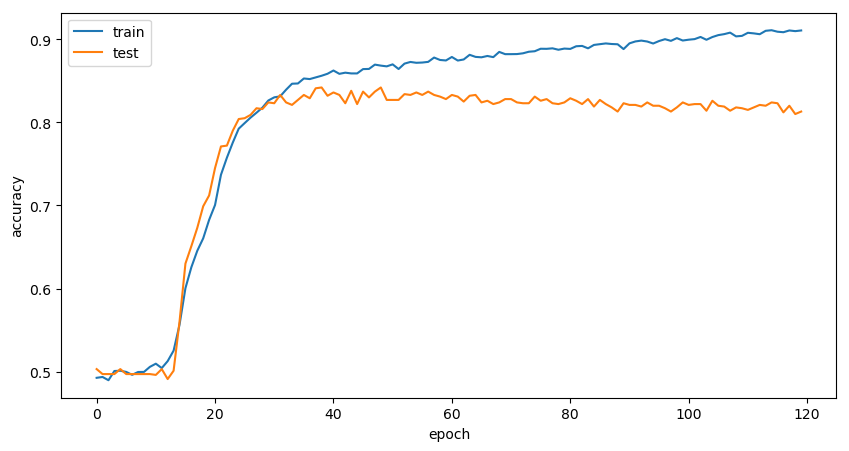

In [54]:
##plotting accuracy

import matplotlib.pyplot as plt
%matplotlib inline

print(history.history.keys())

fig, ax = plt.subplots(figsize=(10,5))

ax.plot(history.history['accuracy'])
ax.plot(history.history['val_accuracy'])
ax.set_xlabel(xlabel='epoch')
ax.set_ylabel(ylabel='accuracy')
ax.legend(['train','test'])

plt.show()

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


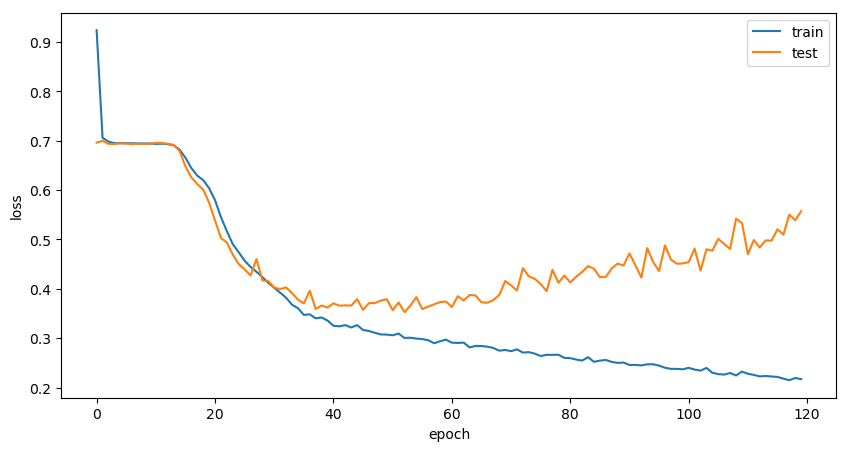

In [58]:
##plotting loss

print(history.history.keys())

fig2, ax2 = plt.subplots(figsize=(10,5))

ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_xlabel(xlabel='epoch')
ax2.set_ylabel(ylabel='loss')
ax2.legend(['train','test'])

plt.show()

In [59]:
print(vocab)

{'bathroom', 'Is', 'left', 'Mary', 'travelled', '?', 'moved', 'picked', 'milk', 'journeyed', 'took', 'discarded', 'the', 'Sandra', 'office', 'put', 'went', 'apple', 'kitchen', 'grabbed', 'football', 'up', 'John', 'down', 'back', 'Daniel', 'there', '.', 'bedroom', 'dropped', 'to', 'garden', 'yes', 'in', 'hallway', 'got', 'no'}


In [88]:
def get_answer(model=model, tokenizer=tokenizer, max_story_len=max_story_len, max_query_len=max_query_len):
    
    ##get story and query as input from user
    story = input("Story: ")
    query = input("Query: ")
    
    ##encode the story and pad it
    story_encoded = [tokenizer.word_index[word.lower()] for word in story.split(' ')]
    story_encoded = pad_sequences([story_encoded], maxlen=max_story_len, truncating='pre')
    
    ##encode the query and pad it
    query_encoded = [tokenizer.word_index[word.lower()] for word in query.split(' ')]
    query_encoded = pad_sequences([query_encoded], maxlen=max_query_len, truncating='pre')
    
    ##get probability distribution over all words in vocab size
    prob = model.predict([story_encoded, query_encoded])
    
    ##get index position of highest probability word
    index_word = np.argmax(prob)
    
    ##get answer
    answer = tokenizer.index_word[index_word]
    
    print(f"Answer: {answer}")
    
    return answer

In [89]:
get_answer(model=model, tokenizer=tokenizer)

Story: Mary is in the garden . John left the hallway .
Query: Is Mary in the garden ?
Answer: yes


'yes'

In [95]:
get_answer(model=model, tokenizer=tokenizer)

Story: John took the milk there . Mary grabbed the apple there . Mary went back to the office . Daniel went to the garden . Daniel went back to the kitchen . John put down the milk . Sandra travelled to the garden . John got the milk there .
Query: Is Daniel in the garden ?
Answer: yes


'yes'